In [11]:
import pandas as pd
import numpy as np
import requests
import rasterio
from rasterio.transform import from_origin, from_bounds
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.image as mpimg
import random
import math
from datetime import datetime
from collections import Counter
import os
import seaborn as sns
from dotenv import load_dotenv

from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix

In [12]:
load_dotenv()

# To replicate results, retrieve an API token from https://ebird.org/api/keygen and specify it in an .env file
EBIRD_API_TOKEN = os.getenv("EBIRD_API_TOKEN")

if not EBIRD_API_TOKEN:
    print("EBIRD_API_TOKEN is not set.")

# List of species to model
SPECIES_LIST = [
    {"code": "amerob", "name": "American Robin"},
    {"code": "pilwoo", "name": "Pileated Woodpecker"},
    {"code": "blujay", "name": "Blue Jay"},
    {"code": "carwre", "name": "Carolina Wren"}
]

REGION = "US-MA"

# Observation count per species
MAX_RESULTS_PER_SPECIES = 250

# Number of absence locations to generate
NUM_ABSENCES_PER_SPECIES = 250

# Environmental data paths
CLIMATE_DATA_DIR = "../../data/wc2.1_30s_bio" # Directory containing WorldClim data
BIO_TEMP_PATH = os.path.join(CLIMATE_DATA_DIR, "wc2.1_30s_bio_1.tif") # Annual Mean Temp
BIO_PRECIP_PATH = os.path.join(CLIMATE_DATA_DIR, "wc2.1_30s_bio_12.tif") # Annual Precip
BIO_TEMP_SEASONALITY_PATH = os.path.join(CLIMATE_DATA_DIR, "wc2.1_30s_bio_4.tif") # Temp Seasonality
BIO_PRECIP_SEASONALITY_PATH = os.path.join(CLIMATE_DATA_DIR, "wc2.1_30s_bio_15.tif") # Precip Seasonality

ELEV_PATH = os.path.join(CLIMATE_DATA_DIR, "wc2.1_30s_elev.tif") # Elevation

# Params for prediction map
MAP_RESOLUTION = 0.01  # Res of prediction grid in degrees

In [13]:
# Gets presence data from eBird given the species code, region, and the maximum amount of observations to retrieve
def get_ebird_data(species_code, region, max_results):
    url = f"https://api.ebird.org/v2/data/obs/{region}/recent/{species_code}"
    headers = {"X-eBirdApiToken": EBIRD_API_TOKEN}
    params = {"maxResults": max_results}

    try:
        res = requests.get(url, headers=headers, params=params)
        res.raise_for_status()
        data = res.json()
        presence_df = pd.DataFrame(data)

        presence_df = presence_df[['lat', 'lng']]
        presence_df.rename(columns={'lat': 'latitude', 'lng': 'longitude'}, inplace=True)
        presence_df['species_code'] = species_code
        presence_df['present'] = 1

        return presence_df

    except requests.exceptions.RequestException as e:
        print(f"Error fetching data for {species_code}.")
        return pd.DataFrame()


# Given a list of latitude and longitudes, this function converts them into coordinates and retrieves the respective data like precipitation and elevation from the respective coordinates in the raster (tif) file. 
def get_raster_info_from_path(lat_long_list, path):
    try:
        with rasterio.open(path) as img:
            coords = []
            for lat, long in lat_long_list:
                coords.append((long, lat))
                
            results = []

            for data in img.sample(coords):
                value = data[0]
            
                if value != img.nodata:
                    results.append(value)
                else:
                    results.append(None)
            
            return results

    except:
        print("Can't read raster file.")
        return [None] * len(lat_long_list)

# Since eBird only returns presence data, we have to generate our own absence data by sampling random locations and making sure those locations aren't too close to known presence locations.
def populate_data_with_absences(presence_df, species_code, region_bounds, max_results):
    min_lat, max_lat, min_long, max_long = region_bounds
    presence_locations = set(zip(presence_df['latitude'], presence_df['longitude']))

    absences = []
    while len(absences) < max_results:
        lat = min_lat + (max_lat - min_lat) * random.random()
        long = min_long + (max_long - min_long) * random.random()

        for presence_lat, presence_long in presence_locations:
            if all(math.sqrt((lat - presence_lat)**2 + (long - presence_long)**2) > 0.01):
                absences.append((lat, long))

    absence_df = pd.DataFrame(absences, columns=['latitude', 'longitude'])
    absence_df['species_code'] = species_code
    absence_df['present'] = 0

    return absence_df

In [14]:
# Generates the dataset of present and absent observations as a csv file
def create_dataset():
    dataset = []
    region_bounds = None

    for species in SPECIES_LIST:
        species_code = species["code"]
        species_name = species["name"]

        presence_df = get_ebird_data(species_code, REGION, MAX_RESULTS_PER_SPECIES)

        if presence_df.empty:
            continue

        presence_df['species_name'] = species_name

        if region_bounds is None:
            region_bounds = (presence_df['latitude'].min(), presence_df['latitude'].max(), presence_df['longitude'].min(), presence_df['longitude'].max())
        else:
            min_lat, max_lat, min_long, max_long = region_bounds
            region_bounds = (min(min_lat, presence_df['latitude'].min()), max(max_lat, presence_df['latitude'].max()), min(min_long, presence_df['longitude'].min()), max(max_long, presence_df['longitude'].max()))

        absence_df = populate_data_with_absences(presence_df, species_code, region_bounds, NUM_ABSENCES_PER_SPECIES)

        absence_df['species_name'] = species_name

        species_df = pd.concat([presence_df, absence_df], ignore_index=True)
        dataset.append(species_df)

    if not dataset:
        return None, None

    merged_df = pd.concat(dataset, ignore_index=True)

    coords = list(zip(merged_df['latitude'], merged_df['longitude']))

    temperature_vals = []
    for val in get_raster_info_from_path(coords, BIO_TEMP_PATH):
        if val is not None:
            temperature_vals.append(val)
        else:
            temperature_vals.append(None)
    merged_df['temperature'] = temperature_vals
    merged_df['precipitation'] = get_raster_info_from_path(coords, BIO_PRECIP_PATH)
    merged_df['elevation'] = get_raster_info_from_path(coords, ELEV_PATH)

    merged_df.dropna(inplace=True)

    merged_df.to_csv("../../data/TabularData/dataset.csv", index=False)

    return merged_df

In [15]:
# Inspiration: https://medium.com/@enozeren/building-a-random-forest-model-from-scratch-81583cbaa7a9
# Inspiration: https://carbonati.github.io/posts/random-forests-from-scratch/

# A node in the decision tree; holds splitting condition
class DecisionNode:
    def __init__(self, feature_idx=None, threshold=None, left=None, right=None, value=None):
        self.feature_idx = feature_idx
        self.threshold = threshold
        self.left = left
        self.right = right
        self.value = value

# A single decision tree for classification
class DecisionTree:
    def __init__(self, max_depth=5, min_samples_split=2, max_features=None):
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.max_features = max_features
        self.root = None
        self.feature_importances_ = None # set after fitting the model

    def _calculate_leaf_value(self, y):
        if len(y) == 0:
            return 0.5
        return np.mean(y)
    
    def _split(self, X_feature, threshold):
        left_idxs = np.argwhere(X_feature <= threshold).flatten()
        right_idxs = np.argwhere(X_feature > threshold).flatten()
        return left_idxs, right_idxs
    
    def _gini(self, y):
        n = len(y)
        if n == 0:
            return 0
        
        class_counts = {}
        for label in y:
            if label in class_counts:
                class_counts[label] += 1
            else:
                class_counts[label] = 1
        
        gini = 1.0
        for count in class_counts.values():
            prob = count / n
            gini -= prob ** 2
            
        return gini

    def _best_split(self, X, y, feature_idxs):
        best_gain = -float("inf")
        best_feature, best_threshold = None, None
    
        current_impurity = self._gini(y)
        
        for feature_idx in feature_idxs:
            X_feature = X[:, feature_idx]
            thresholds = np.unique(X_feature)
        
            for threshold in thresholds:
                left_idxs, right_idxs = self._split(X_feature, threshold)
                
                if len(left_idxs) == 0 or len(right_idxs) == 0:
                    continue
                
                left_impurity = self._gini(y[left_idxs])
                right_impurity = self._gini(y[right_idxs])
                
                n = len(y)
                n_left, n_right = len(left_idxs), len(right_idxs)
                weighted_impurity = (n_left/n) * left_impurity + (n_right/n) * right_impurity
                
                information_gain = current_impurity - weighted_impurity
                
                if information_gain > best_gain:
                    best_gain = information_gain
                    best_feature = feature_idx
                    best_threshold = threshold
        
        return best_feature, best_threshold, best_gain

    def _grow_tree(self, X, y, depth):
        n_samples, n_features = X.shape
        
        n_classes = len(np.unique(y))
        
        if (depth >= self.max_depth or n_samples < self.min_samples_split or n_classes == 1):
            leaf_value = self._calculate_leaf_value(y)
            return DecisionNode(value=leaf_value)
        
        feature_idxs = np.random.choice(n_features, self.max_features, replace=False)
        
        best_feature, best_threshold, best_gain = self._best_split(X, y, feature_idxs)
        
        if best_feature is not None:
            self.feature_importances_[best_feature] += best_gain
        
        if best_feature is None:
            leaf_value = self._calculate_leaf_value(y)
            return DecisionNode(value=leaf_value)
        
        left_idxs, right_idxs = self._split(X[:, best_feature], best_threshold)
        
        left = self._grow_tree(X[left_idxs], y[left_idxs], depth + 1)
        right = self._grow_tree(X[right_idxs], y[right_idxs], depth + 1)
        
        return DecisionNode(best_feature, best_threshold, left, right)

    # Train the decision tree on the input features X and labels y 
    def fit(self, X, y):
        X = np.array(X)
        y = np.array(y)
        n_samples, n_features = X.shape
        
        if self.max_features is None:
            self.max_features = n_features
        elif self.max_features == 'sqrt':
            self.max_features = int(np.sqrt(n_features)) # use a subset of features
        
        self.feature_importances_ = np.zeros(n_features)
        
        self.root = self._grow_tree(X, y, depth=0)
        
        if np.sum(self.feature_importances_) > 0:
            self.feature_importances_ = self.feature_importances_ / np.sum(self.feature_importances_)

    def _predict_proba_tree(self, x, node):
        if node.value is not None:
            return node.value
        
        if x[node.feature_idx] <= node.threshold:
            return self._predict_proba_tree(x, node.left)
        return self._predict_proba_tree(x, node.right)

    # Predict class probabilities for all instances in X
    def predict_proba(self, X):
        X = np.array(X)
        results = []
        for x in X:
            pred = self._predict_proba_tree(x, self.root)
            results.append(pred)
        return np.array(results)


    # Predict binary class labels based on a given threshold with the default being 0.5
    def predict(self, X, threshold=0.5):
        proba = self.predict_proba(X)
        return np.array(proba >= threshold, dtype=int)

In [16]:
# A random forest with multiple decision trees
class RandomForest:
    def __init__(self, n_trees=100, max_depth=10, min_samples_split=2, max_features='sqrt'):
        self.n_trees = n_trees
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.max_features = max_features
        self.trees = []
        self.feature_importances_ = None

    # Train the random forest by fitting multiple bootstrap-sampled trees
    def fit(self, X, y):
        X = np.array(X)
        y = np.array(y)
        n_features = X.shape[1]
    
        self.trees = []
        feature_importances = np.zeros(n_features)
    
        for i in range(self.n_trees):
            idxs = np.random.choice(len(X), size=len(X), replace=True)
            X_bootstrap, y_bootstrap = X[idxs], y[idxs]
    
            tree = DecisionTree(
                max_depth=self.max_depth,
                min_samples_split=self.min_samples_split,
                max_features=self.max_features
            )
            tree.fit(X_bootstrap, y_bootstrap)
    
            self.trees.append(tree)
            feature_importances += tree.feature_importances_

        self.feature_importances_ = feature_importances / self.n_trees if self.n_trees > 0 else feature_importances


    # Predict probabilities by averaging predictions from all trees
    def predict_proba(self, X):
        X = np.array(X)
        tree_preds = []
        for tree in self.trees:
            preds = tree.predict_proba(X)
            tree_preds.append(preds)
        tree_preds = np.array(tree_preds)
        return np.mean(tree_preds, axis=0)

    # Predict class labels using a threshold
    def predict(self, X, threshold=0.5):
        proba = self.predict_proba(X)
        return np.array(proba >= threshold, dtype=int)

In [17]:
# Gradient Boosted Trees that learn based off previous iterations
class GradientBoostedTrees:
    def __init__(self, n_estimators=100, learning_rate=0.1, max_depth=3, min_samples_split=2):
        self.n_estimators = n_estimators
        self.learning_rate = learning_rate
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.trees = []
        self.initial_prediction = None
        self.feature_importances_ = None 

    # Train GBDT by fitting trees to the residuals
    def fit(self, X, y):
        X = np.array(X)
        y = np.array(y, dtype=float)
        n_features = X.shape[1]
    
        self.feature_importances_ = np.zeros(n_features)
        self.initial_prediction = np.mean(y)
        F = np.full(len(y), self.initial_prediction)
    
        for i in range(self.n_estimators):
            neg_grad = y - 1.0 / (1.0 + np.exp(-F))
    
            tree = DecisionTree(
                max_depth=self.max_depth,
                min_samples_split=self.min_samples_split
            )
            tree.fit(X, neg_grad)
    
            update = tree.predict_proba(X)
            F += self.learning_rate * update
    
            self.trees.append(tree)
            self.feature_importances_ += tree.feature_importances_
    
        if np.sum(self.feature_importances_) > 0:
            self.feature_importances_ /= np.sum(self.feature_importances_)


    # Predict probabilities using the sigmoid of the cumulative prediction
    def predict_proba(self, X):
        X = np.array(X)
        
        F = np.full(len(X), self.initial_prediction)
        
        for tree in self.trees:
            update = tree.predict_proba(X)
            F += self.learning_rate * update
        
        proba = 1.0 / (1.0 + np.exp(-F))
        return proba

    # Predict class labels using a probability threshold
    def predict(self, X, threshold=0.5):
        proba = self.predict_proba(X)
        return np.array(proba >= threshold, dtype=int)

In [18]:
# Splits the dataset into training, validation, and test sets
def train_val_test_split(X, y, test_size=0.2, val_size=0.1, random_state=None):
    if random_state is not None:
        np.random.seed(random_state)
    
    n_samples = len(X)
    idxs = np.random.permutation(n_samples)
    
    n_test = int(test_size * n_samples)
    n_val = int(val_size * n_samples)
    n_train = n_samples - n_test - n_val

    train_idxs = idxs[:n_train]
    val_idxs = idxs[n_train:n_train + n_val]
    test_idxs = idxs[n_train + n_val:]

    X_train = X.iloc[train_idxs] if isinstance(X, pd.DataFrame) else X[train_idxs]
    X_val = X.iloc[val_idxs] if isinstance(X, pd.DataFrame) else X[val_idxs]
    X_test = X.iloc[test_idxs] if isinstance(X, pd.DataFrame) else X[test_idxs]

    y_train = y[train_idxs]
    y_val = y[val_idxs]
    y_test = y[test_idxs]

    return X_train, X_val, X_test, y_train, y_val, y_test

# Evaluates a model's performance on test data
# Returns common classification metrics and confusion matrix values
def evaluate_model(model, X_test, y_test, is_sklearn=False):
    if is_sklearn:
        y_prob = model.predict_proba(X_test)[:, 1]
    else:
        y_prob = model.predict_proba(X_test)

    y_pred = (y_prob >= 0.5).astype(int)

    accuracy = np.mean(y_test == y_pred)

    true_pos = np.sum((y_test == 1) & (y_pred == 1))
    false_pos = np.sum((y_test == 0) & (y_pred == 1))
    true_neg = np.sum((y_test == 0) & (y_pred == 0))
    false_neg = np.sum((y_test == 1) & (y_pred == 0))

    precision = true_pos / (true_pos + false_pos) if (true_pos + false_pos) > 0 else 0
    recall = true_pos / (true_pos + false_neg) if (true_pos + false_neg) > 0 else 0
    f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0

    if is_sklearn:
        auc = roc_auc_score(y_test, y_prob)
    else:
        sorted_indices = np.argsort(y_prob)[::-1]
        sorted_y = y_test[sorted_indices]
        tpr = np.cumsum(sorted_y) / np.sum(sorted_y)
        fpr = np.cumsum(1 - sorted_y) / np.sum(1 - sorted_y)
        auc = np.sum((fpr[1:] - fpr[:-1]) * (tpr[1:] + tpr[:-1])) / 2
    
    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'auc': auc,
        'confusion_matrix': {
            'tn': true_neg,
            'fp': false_pos,
            'fn': false_neg,
            'tp': true_pos
        }
    }

# Plots feature importances from a trained model
# Useful for interpreting which variables influenced predictions
def plot_feature_importance(model, feature_names, species_name, model_name):
    is_sklearn = model_name.startswith('SKLearn')

    # in case we want to import future models that may not support feature importance
    if is_sklearn:
        if hasattr(model, 'feature_importances_'):
            importances = model.feature_importances_
        else:
            print(f"Model {model_name} does not support feature importance")
            return
    else:
        if hasattr(model, 'feature_importances_'):
            importances = model.feature_importances_
        else:
            print(f"Model {model_name} does not support feature importance")
            return
    
    indices = np.argsort(importances)[::-1]
    
    plt.figure(figsize=(10, 6))
    plt.title(f'Feature Importance for {species_name} using {model_name}')
    plt.bar(range(len(importances)), importances[indices], align='center')
    plt.xticks(range(len(importances)), [feature_names[i] for i in indices], rotation=45, ha='right')
    plt.tight_layout()
    
    filename = f"../../images/TabularImages/png/feature_importance_{species_name.replace(' ', '_')}_{model_name}.png"
    plt.savefig(filename)
    plt.close()
    
    return indices

# Creates a geographic prediction map using the model and environmental grid
# Used to visualize predicted species distributions across a region
def create_prediction_map(model, grid_df, grid_shape, bounds, species_name, model_name):
    X_grid = grid_df[['latitude', 'longitude', 'temperature', 'precipitation', 'elevation']]
    
    is_sklearn = model_name.startswith('SKLearn')
    if is_sklearn:
        probabilities = model.predict_proba(X_grid)[:, 1]
    else:
        probabilities = model.predict_proba(X_grid)
    
    min_lat, max_lat, min_long, max_long = bounds
    lat_grid = np.linspace(min_lat, max_lat, grid_shape[0])
    long_grid = np.linspace(min_long, max_long, grid_shape[1])
 
    long_mesh, lat_mesh = np.meshgrid(long_grid, lat_grid)

    prob_grid = np.zeros(grid_shape) - 9999 # no data value in raster
   
    for i, (lat, long) in enumerate(zip(grid_df['latitude'], grid_df['longitude'])):
        lat_idx = np.abs(lat_grid - lat).argmin()
        long_idx = np.abs(long_grid - long).argmin()
        
        prob_grid[lat_idx, long_idx] = probabilities[i]
    
    cmap = LinearSegmentedColormap.from_list(
        'natural',
            [
                (0, '#c2b280'),
                (0.5, '#ede6d6'),
                (1, '#4e6e4e')
            ]
    )
    
    plt.figure(figsize=(12, 8))
    plt.title(f'{species_name} Presence Probability using {model_name}')

    masked_grid = np.ma.masked_where(prob_grid < 0, prob_grid)

    plt.pcolormesh(long_mesh, lat_mesh, masked_grid, cmap=cmap, vmin=0, vmax=1)
    plt.colorbar(label='Probability of Presence')

    plt.xlabel('Longitude')
    plt.ylabel('Latitude')

    filename = f"../../images/TabularImages/png/distribution_map_{species_name.replace(' ', '_')}_{model_name}.png"
    plt.savefig(filename, dpi=300, bbox_inches='tight')
    plt.close()

    try:
        tif_filename = f"../../images/TabularImages/tif/distribution_map_{species_name.replace(' ', '_')}_{model_name}.tif"

        transform = from_bounds(min_long, min_lat, max_long, max_lat, grid_shape[1], grid_shape[0])
 
        with rasterio.open(
            tif_filename,
            'w',
            driver='GTiff',
            height=grid_shape[0],
            width=grid_shape[1],
            count=1,
            dtype=prob_grid.dtype,
            crs='+proj=longlat +ellps=WGS84 +datum=WGS84 +no_defs',
            transform=transform,
            nodata=-9999
        ) as dst:
            dst.write(prob_grid, 1)
        
    except ImportError:
        print("Rasterio import not found.")
    
    return prob_grid

Model Performance Summary

American Robin:
  - RandomForest:
      - Validation: Accuracy=0.8571, AUC=0.9239
      - Test: Accuracy=0.8028, AUC=0.8422


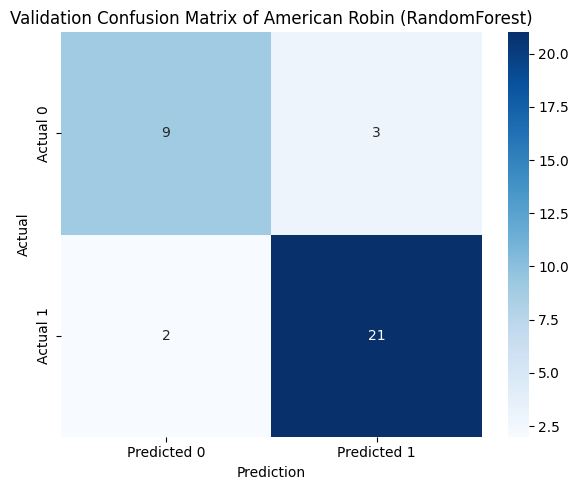

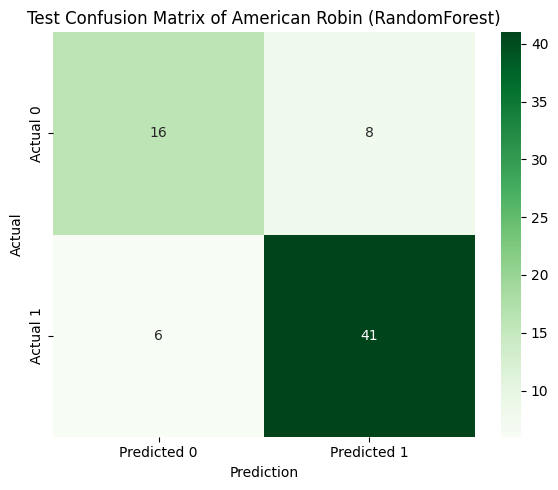

  - GradientBoostedTrees:
      - Validation: Accuracy=0.7714, AUC=0.8478
      - Test: Accuracy=0.7324, AUC=0.7216


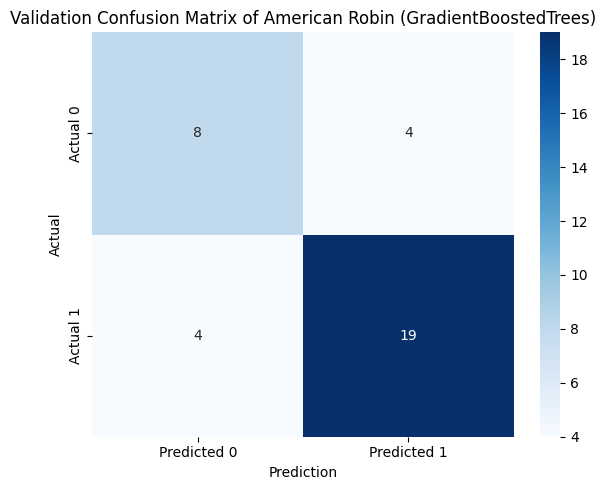

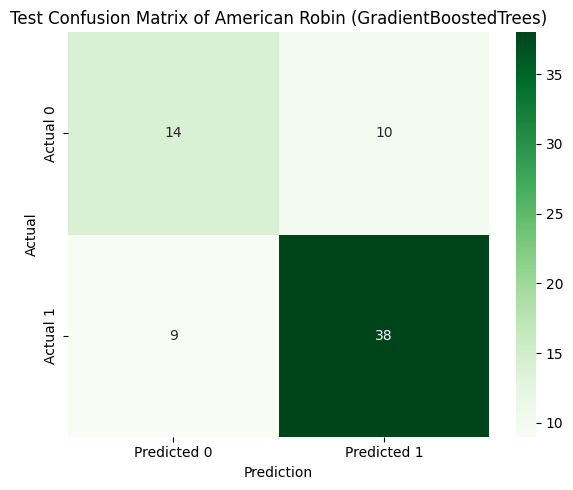

  - SKLearn_RandomForest:
      - Validation: Accuracy=0.8571, AUC=0.9384
      - Test: Accuracy=0.7887, AUC=0.8085


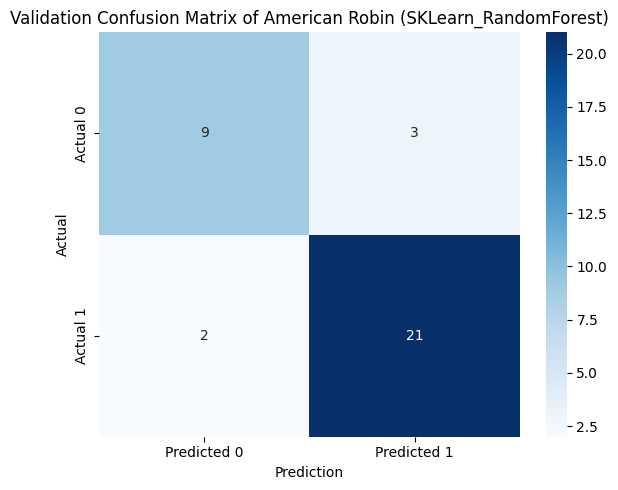

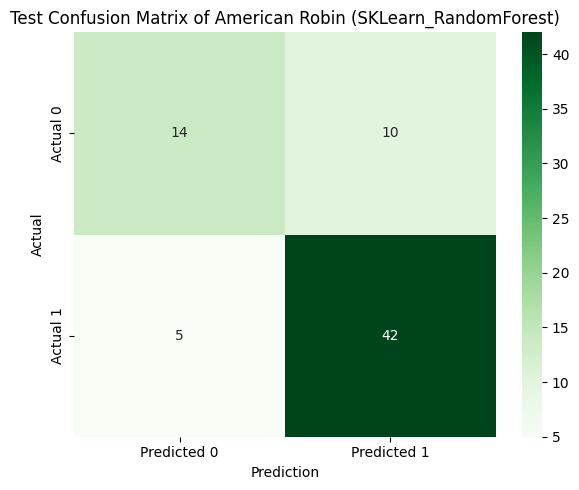

  - SKLearn_GradientBoosting:
      - Validation: Accuracy=0.8857, AUC=0.9420
      - Test: Accuracy=0.8310, AUC=0.7846


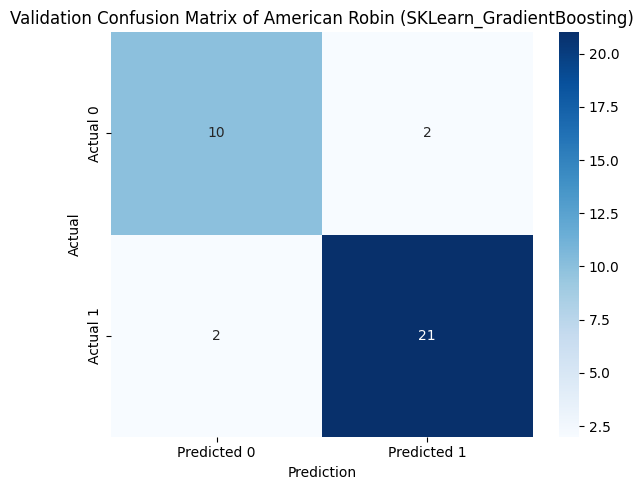

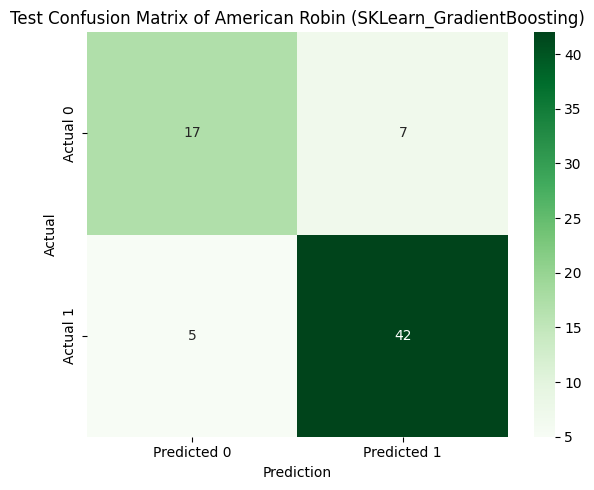


Pileated Woodpecker:
  - RandomForest:
      - Validation: Accuracy=0.8286, AUC=0.8720
      - Test: Accuracy=0.8732, AUC=0.8945


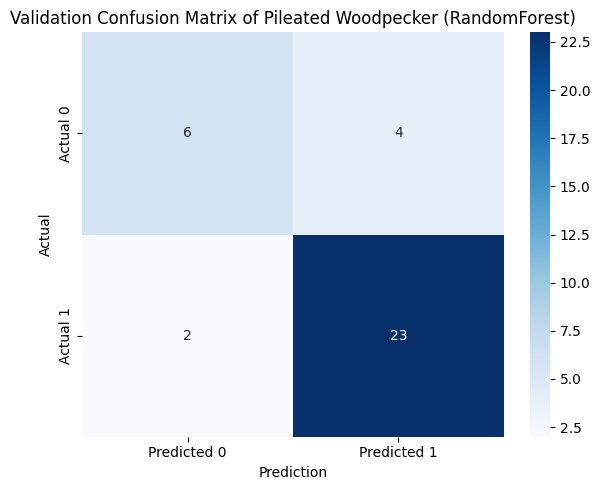

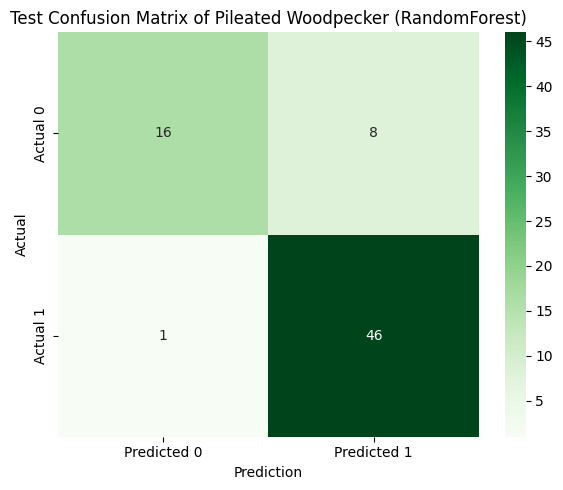

  - GradientBoostedTrees:
      - Validation: Accuracy=0.8571, AUC=0.7680
      - Test: Accuracy=0.8732, AUC=0.9264


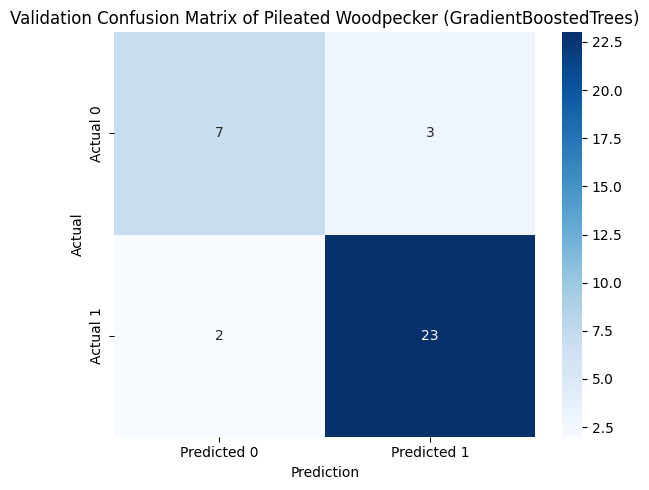

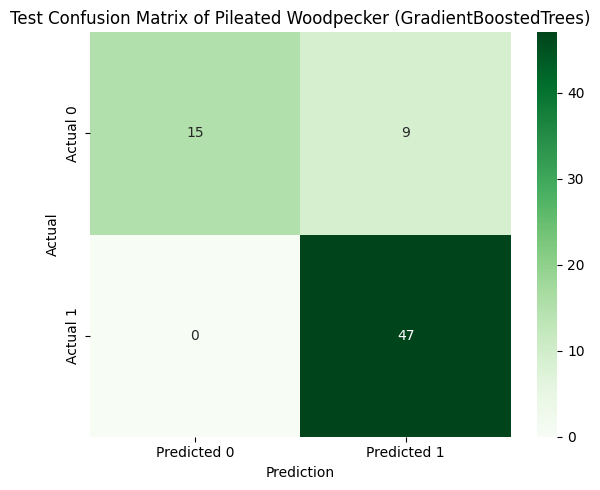

  - SKLearn_RandomForest:
      - Validation: Accuracy=0.8286, AUC=0.9100
      - Test: Accuracy=0.9155, AUC=0.9140


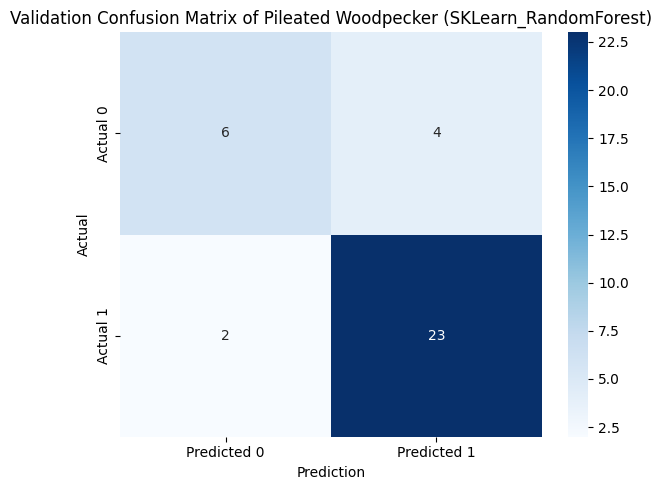

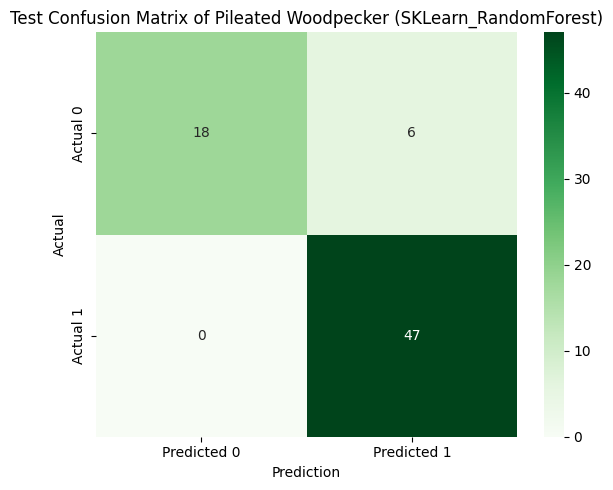

  - SKLearn_GradientBoosting:
      - Validation: Accuracy=0.8000, AUC=0.8840
      - Test: Accuracy=0.8873, AUC=0.8635


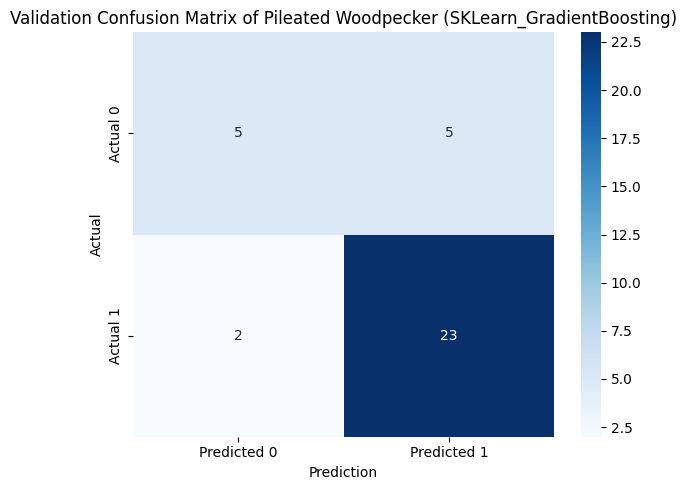

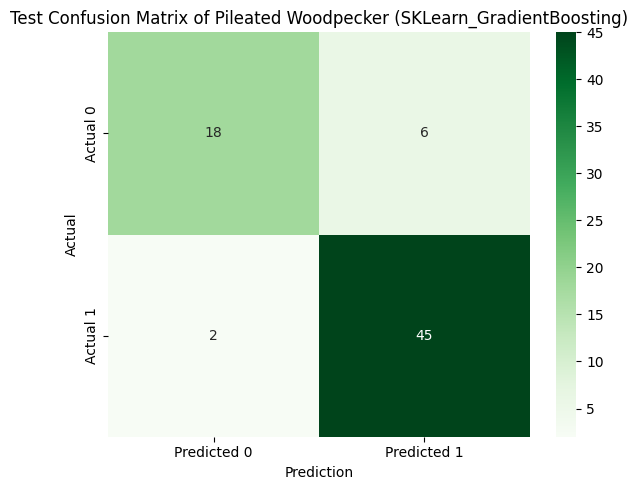


Blue Jay:
  - RandomForest:
      - Validation: Accuracy=0.9143, AUC=0.9583
      - Test: Accuracy=0.8451, AUC=0.8369


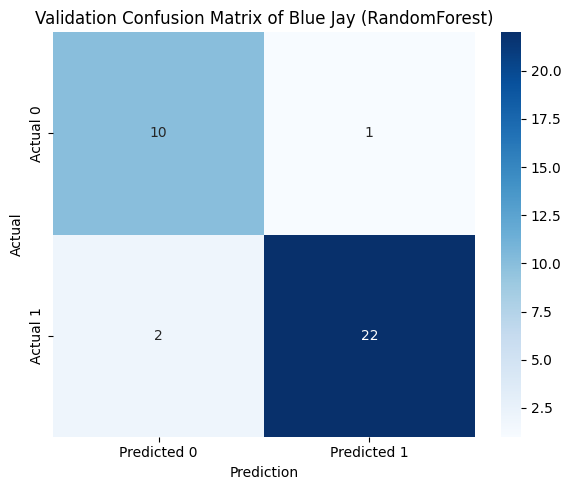

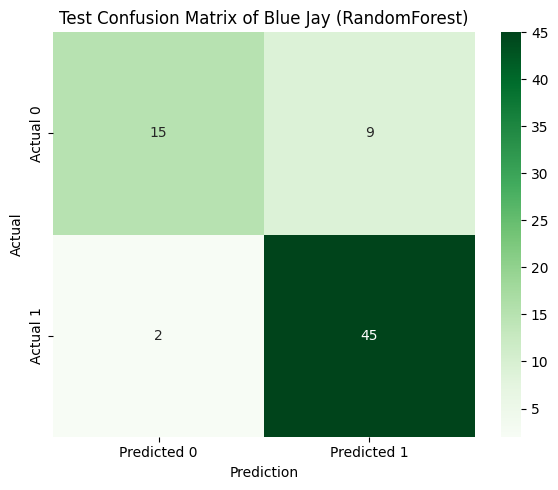

  - GradientBoostedTrees:
      - Validation: Accuracy=0.7714, AUC=0.7197
      - Test: Accuracy=0.7465, AUC=0.8014


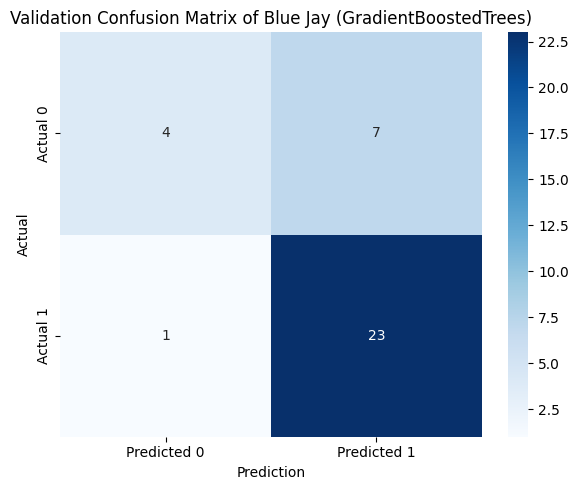

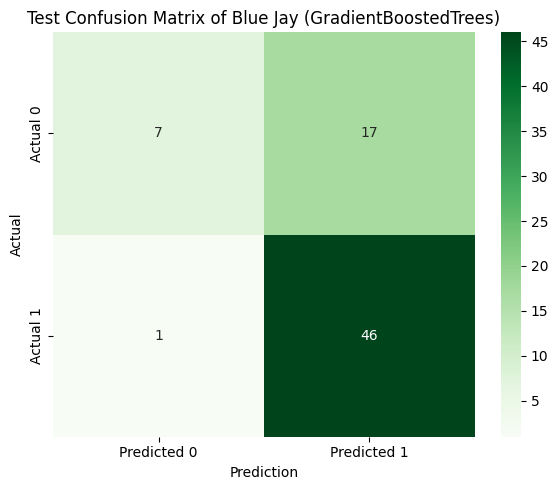

  - SKLearn_RandomForest:
      - Validation: Accuracy=0.9143, AUC=0.9621
      - Test: Accuracy=0.8169, AUC=0.8692


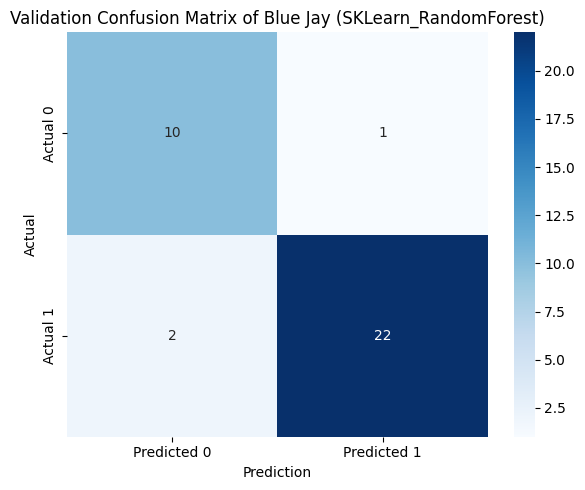

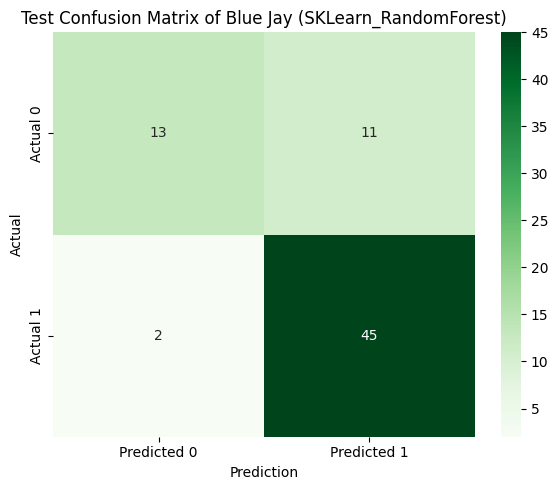

  - SKLearn_GradientBoosting:
      - Validation: Accuracy=0.8857, AUC=0.9356
      - Test: Accuracy=0.7606, AUC=0.8426


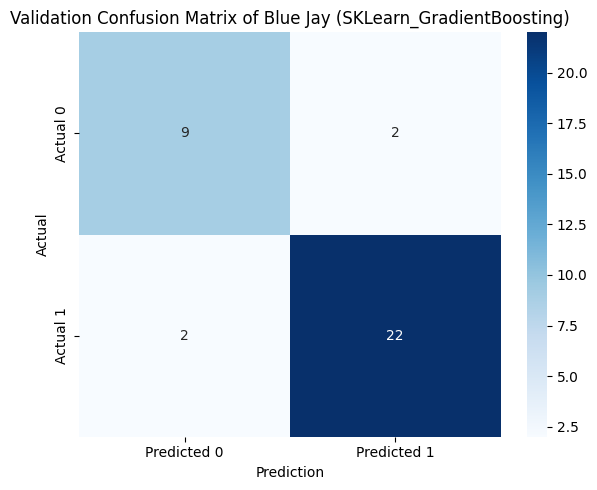

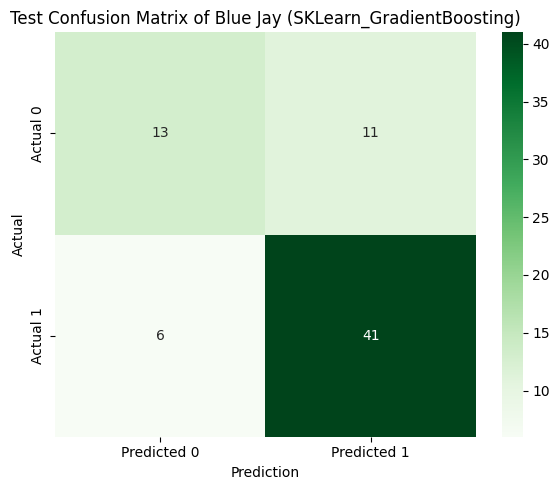


Carolina Wren:
  - RandomForest:
      - Validation: Accuracy=0.9706, AUC=0.9423
      - Test: Accuracy=0.8841, AUC=0.8847


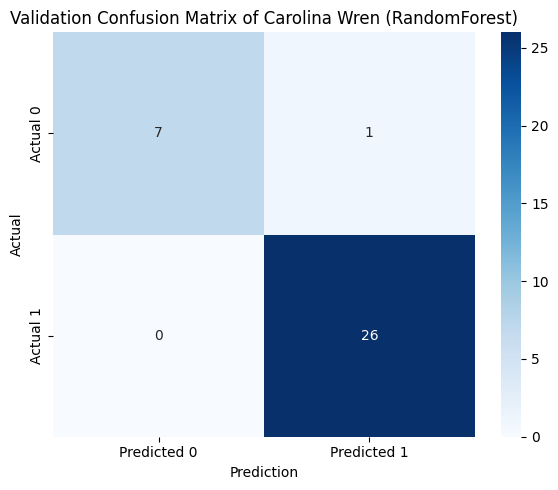

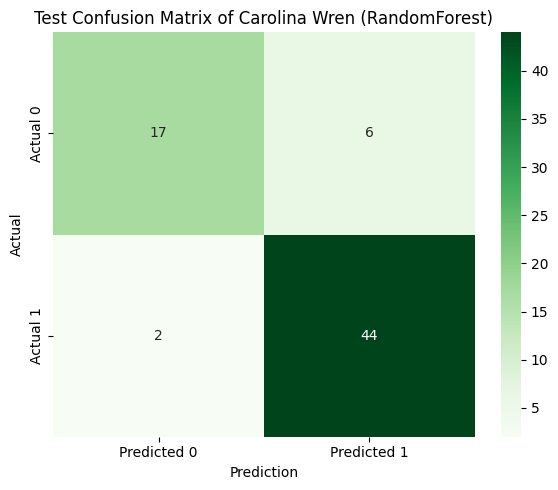

  - GradientBoostedTrees:
      - Validation: Accuracy=0.9412, AUC=0.9808
      - Test: Accuracy=0.8986, AUC=0.8715


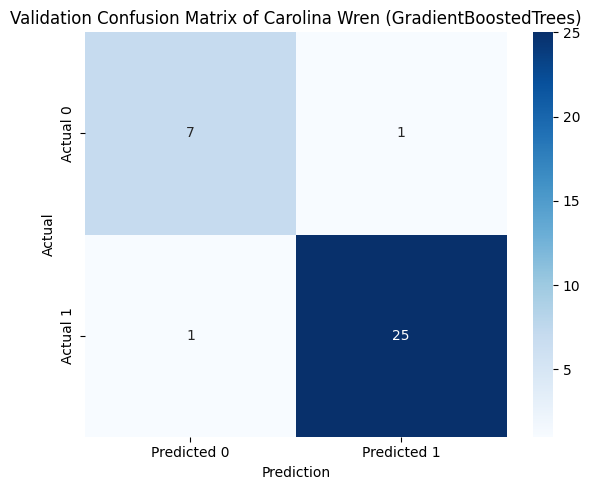

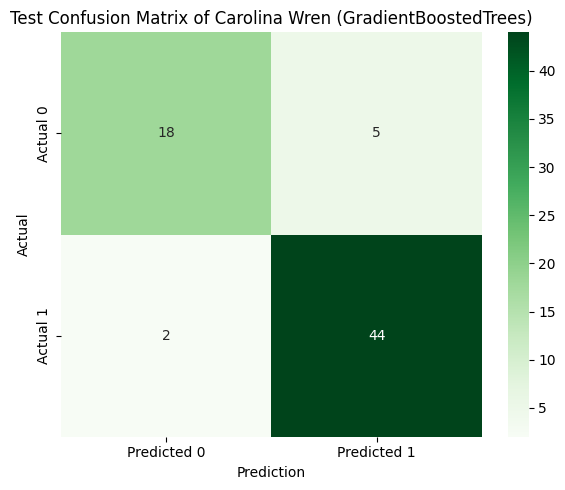

  - SKLearn_RandomForest:
      - Validation: Accuracy=0.9412, AUC=0.9038
      - Test: Accuracy=0.8696, AUC=0.8592


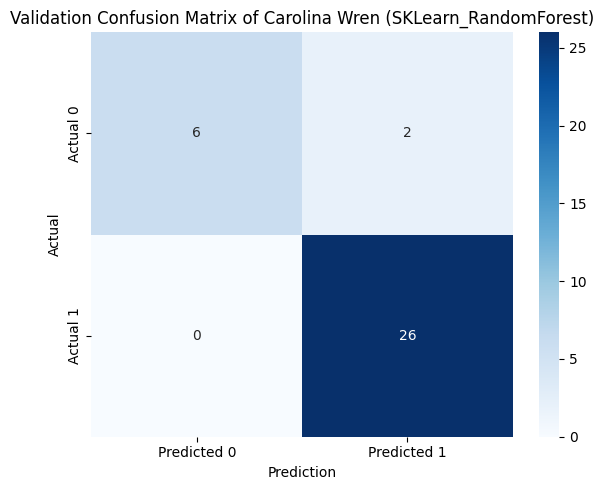

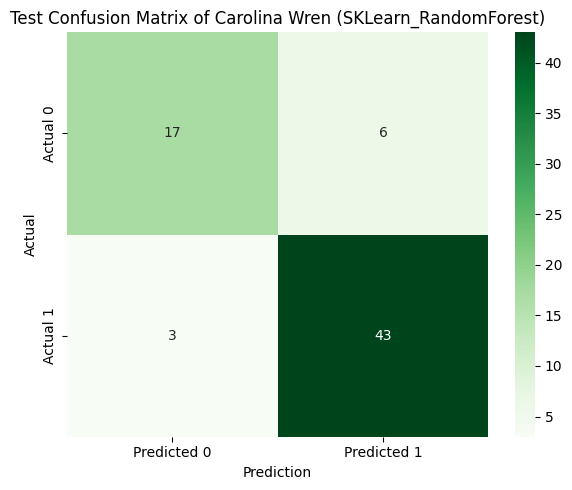

  - SKLearn_GradientBoosting:
      - Validation: Accuracy=0.8824, AUC=0.9423
      - Test: Accuracy=0.8841, AUC=0.8828


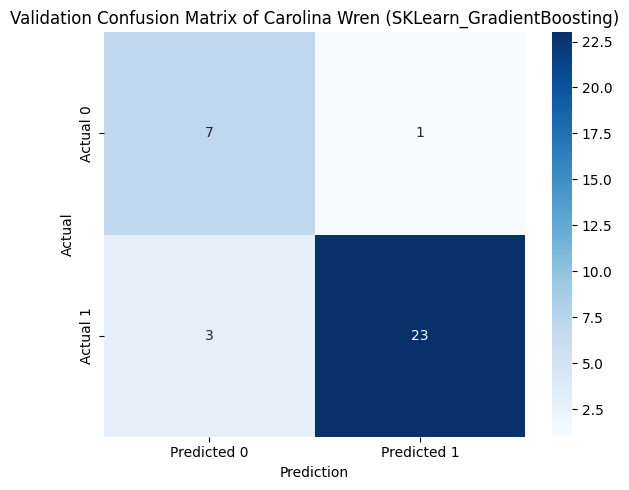

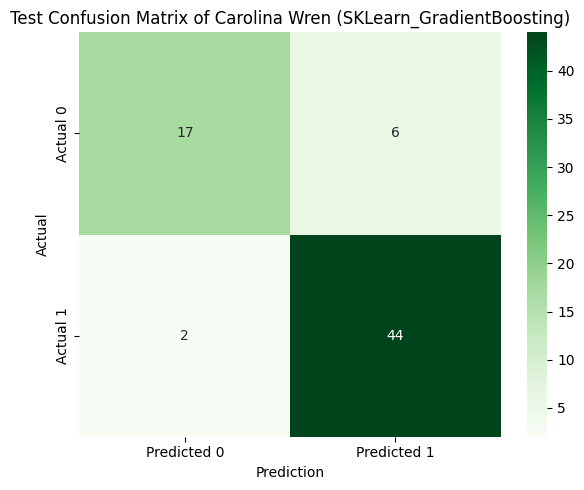

In [19]:
def main():
    try:
        data_df = pd.read_csv("../../data/TabularData/dataset.csv")
    except FileNotFoundError:
        data_df = create_dataset()
        if data_df is None:
            print("\nFailed to create dataset.")
            return
            
    def create_prediction_grid():
        min_lat = data_df['latitude'].min() - 0.1
        max_lat = data_df['latitude'].max() + 0.1
        min_long = data_df['longitude'].min() - 0.1
        max_long = data_df['longitude'].max() + 0.1
        bounds = (min_lat, max_lat, min_long, max_long)
   
        grid_lats = np.arange(min_lat, max_lat, MAP_RESOLUTION)
        grid_longs = np.arange(min_long, max_long, MAP_RESOLUTION)
        grid_shape = (len(grid_lats), len(grid_longs))
    
        grid_points = []
        for long in grid_longs:
            for lat in grid_lats:
                grid_points.append((lat, long))
    
        grid_df = pd.DataFrame(grid_points, columns=['latitude', 'longitude'])
    
        coords = list(zip(grid_df['latitude'], grid_df['longitude']))
        grid_df['temperature'] = get_raster_info_from_path(coords, BIO_TEMP_PATH)
        grid_df['precipitation'] = get_raster_info_from_path(coords, BIO_PRECIP_PATH)
        grid_df['elevation'] = get_raster_info_from_path(coords, ELEV_PATH)
    
        grid_df.dropna(inplace=True)
        
        return (grid_df, grid_shape, bounds)

    grid_data = create_prediction_grid()
    
    res_species = {}
    
    species_list = [(code, name) for code, name in zip(data_df['species_code'].unique(), data_df['species_name'].unique())]
    
    for species_code, species_name in species_list:
        species_df = data_df[data_df['species_code'] == species_code].copy()
        
        X = species_df[['latitude', 'longitude', 'temperature', 'precipitation', 'elevation']]
        y = species_df['present'].values
        
        X_train, X_val, X_test, y_train, y_val, y_test = train_val_test_split(X, y, test_size=0.2, val_size=0.1, random_state=42)
        
        models = {
            'RandomForest': RandomForest(n_trees=100, max_depth=10, min_samples_split=2),
            'GradientBoostedTrees': GradientBoostedTrees(n_estimators=100, learning_rate=0.1, max_depth=3),
            'SKLearn_RandomForest': RandomForestClassifier(n_estimators=100, max_depth=10, min_samples_split=2, random_state=42),
            'SKLearn_GradientBoosting': GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)
        }
        
        species_results = {}
        
        for name, model in models.items():
            model.fit(X_train, y_train)
            
            is_sklearn = name.startswith('SKLearn')
            val_metrics = evaluate_model(model, X_val, y_val, is_sklearn=is_sklearn)

            test_metrics = evaluate_model(model, X_test, y_test, is_sklearn=is_sklearn)

            species_results[name] = {
                'validation': val_metrics,
                'test': test_metrics
            }

            feature_names = X.columns
            plot_feature_importance(model, feature_names, species_name, name)
        
            if grid_data is not None:
                grid_df, grid_shape, bounds = grid_data
                create_prediction_map(model, grid_df, grid_shape, bounds, species_name, name)
        
        res_species[species_name] = species_results

    print("Model Performance Summary")
    for species, results in res_species.items():
        print(f"\n{species}:")
        for model_name, metrics in results.items():
            val_metrics = metrics['validation']
            test_metrics = metrics['test']
            
            print(f"  - {model_name}:")
            print(f"      - Validation: Accuracy={val_metrics['accuracy']:.4f}, AUC={val_metrics['auc']:.4f}")
            print(f"      - Test: Accuracy={test_metrics['accuracy']:.4f}, AUC={test_metrics['auc']:.4f}")
    
            val_cm = np.array([
                [val_metrics['confusion_matrix']['tn'], val_metrics['confusion_matrix']['fp']],
                [val_metrics['confusion_matrix']['fn'], val_metrics['confusion_matrix']['tp']]
            ])
    
            plt.figure(figsize=(6, 5))
            sns.heatmap(val_cm, annot=True, fmt='d', cmap='Blues',
                        xticklabels=['Predicted 0', 'Predicted 1'],
                        yticklabels=['Actual 0', 'Actual 1'])
            plt.title(f'Validation Confusion Matrix of {species} ({model_name})')
            plt.xlabel('Prediction')
            plt.ylabel('Actual')
            plt.tight_layout()
            plt.show()
    
            test_cm = np.array([
                [test_metrics['confusion_matrix']['tn'], test_metrics['confusion_matrix']['fp']],
                [test_metrics['confusion_matrix']['fn'], test_metrics['confusion_matrix']['tp']]
            ])
    
            plt.figure(figsize=(6, 5))
            sns.heatmap(test_cm, annot=True, fmt='d', cmap='Greens',
                        xticklabels=['Predicted 0', 'Predicted 1'],
                        yticklabels=['Actual 0', 'Actual 1'])
            plt.title(f'Test Confusion Matrix of {species} ({model_name})')
            plt.xlabel('Prediction')
            plt.ylabel('Actual')
            plt.tight_layout()
            plt.show()

main()

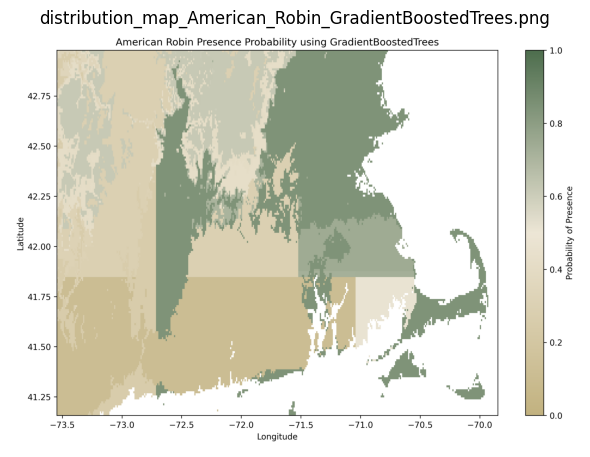

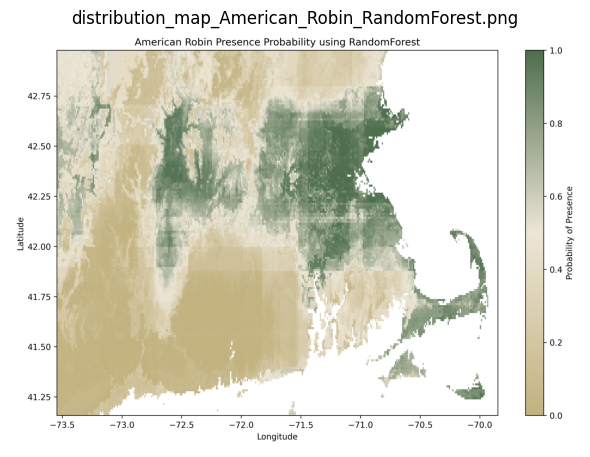

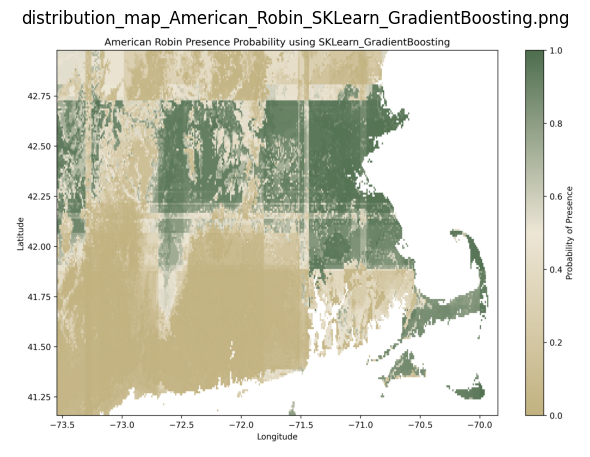

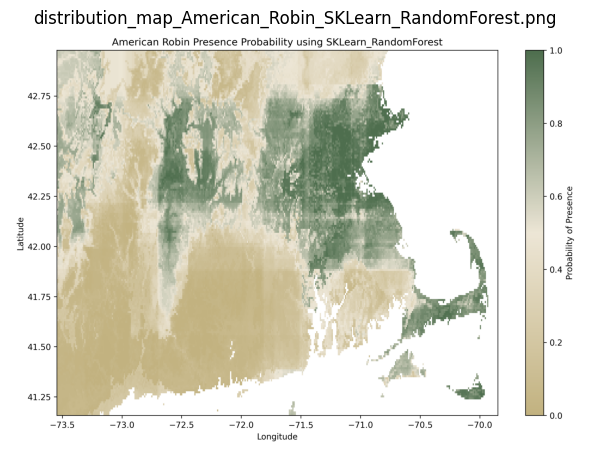

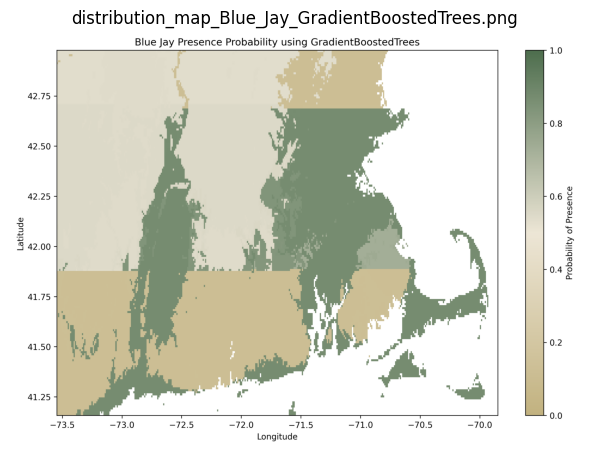

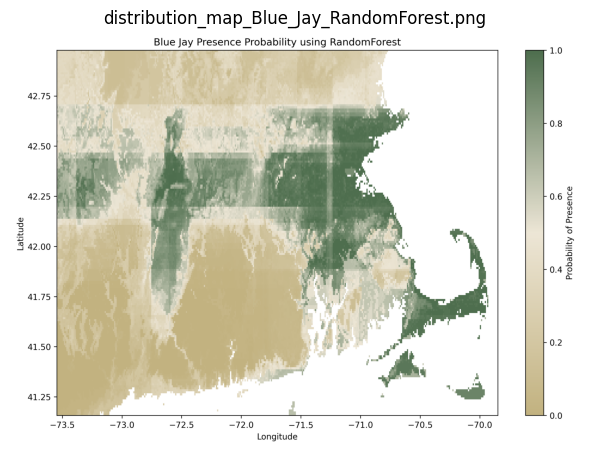

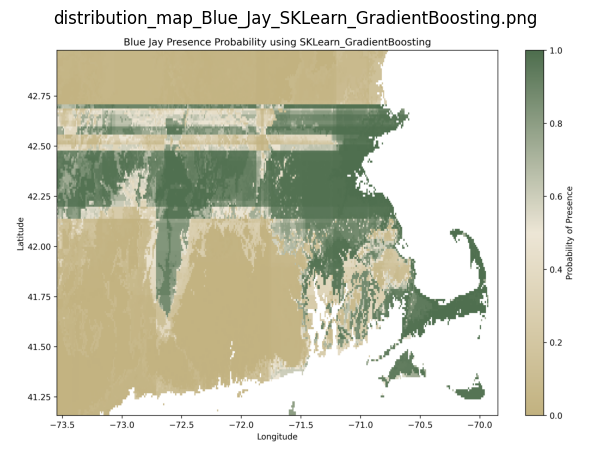

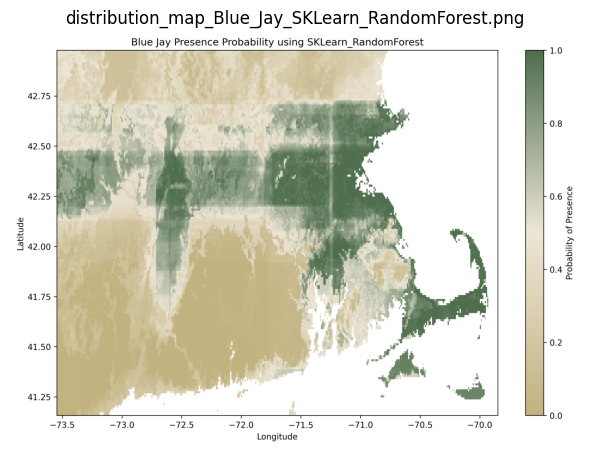

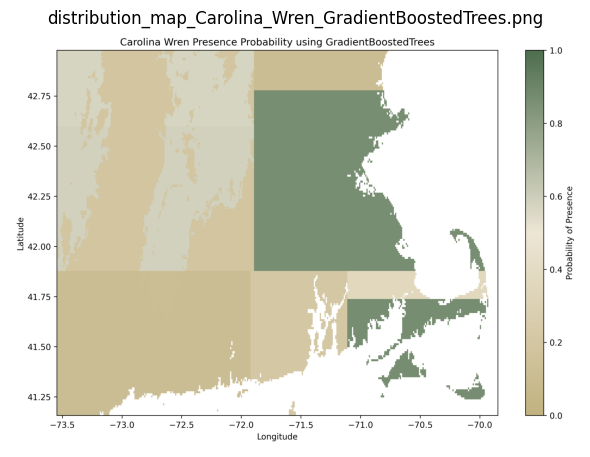

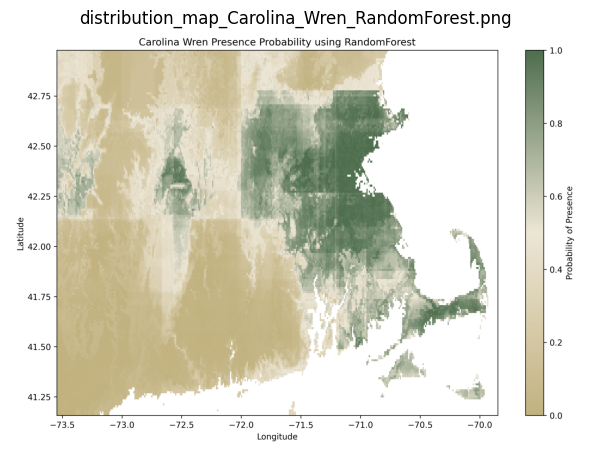

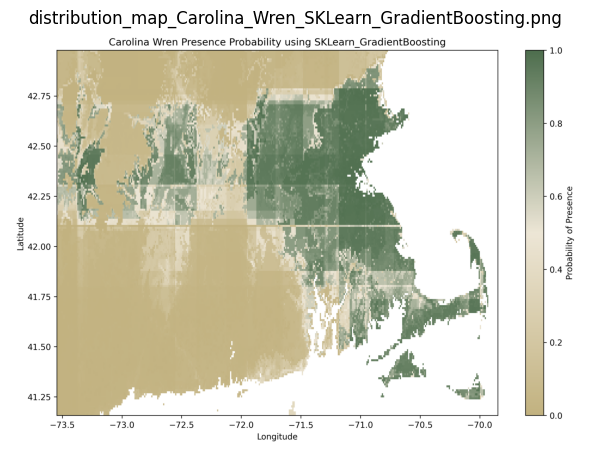

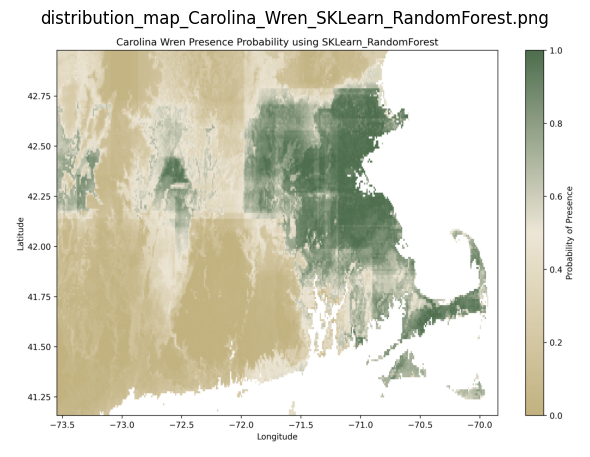

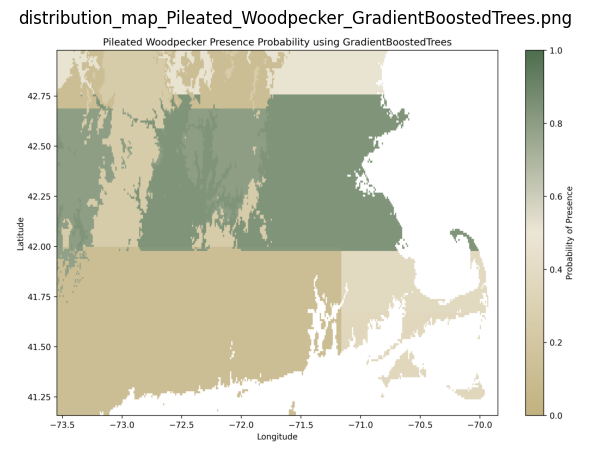

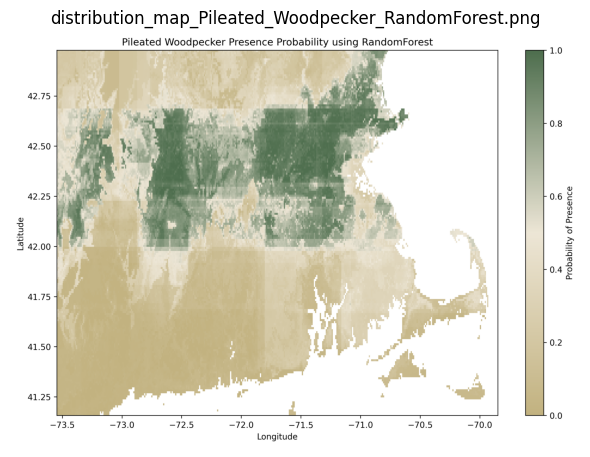

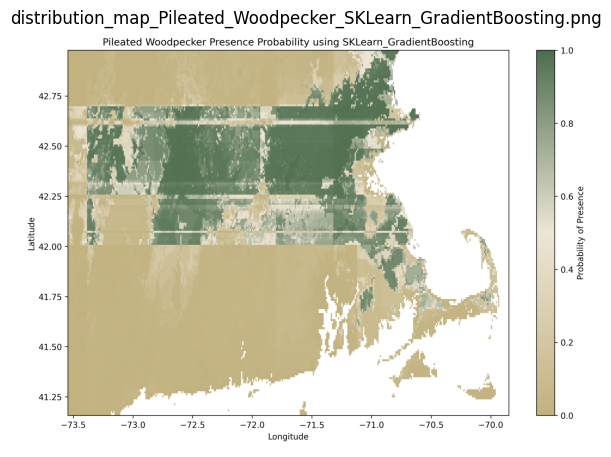

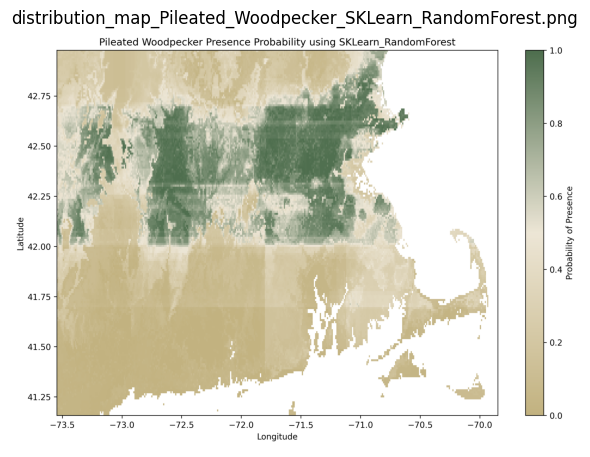

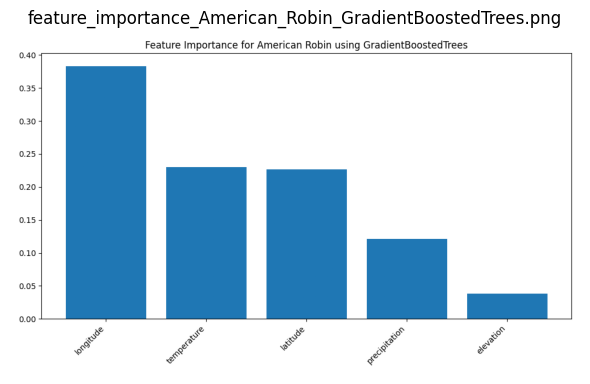

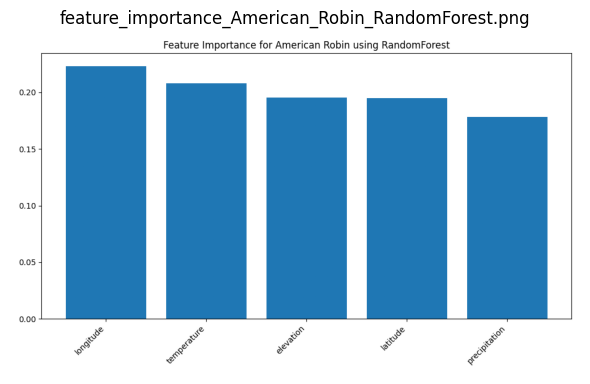

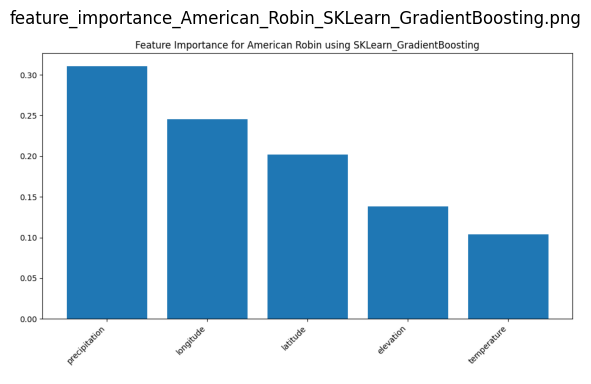

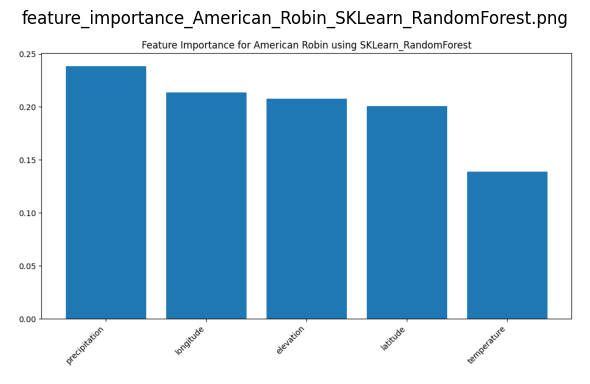

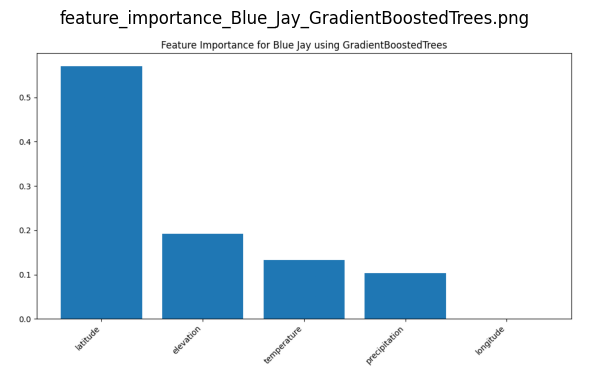

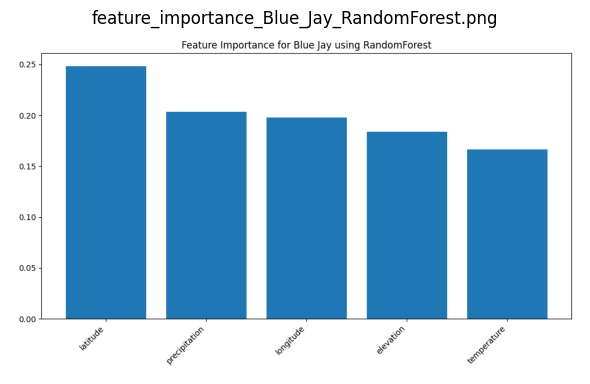

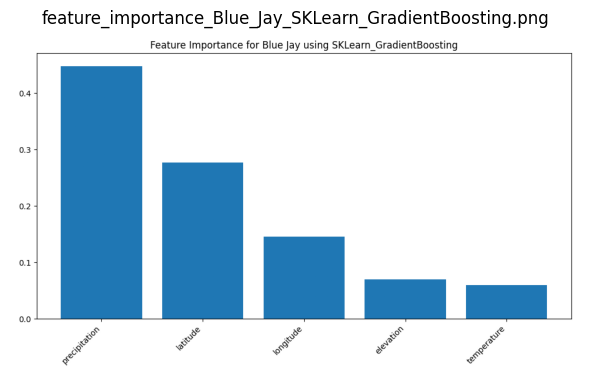

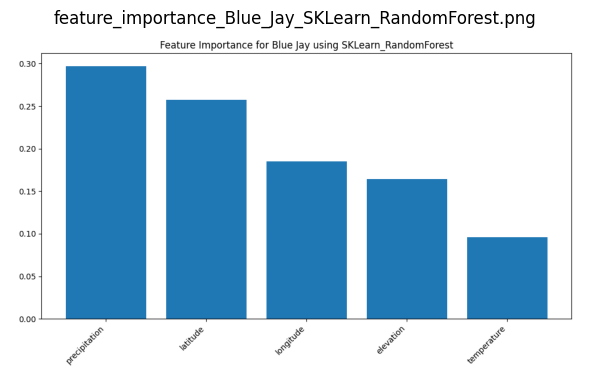

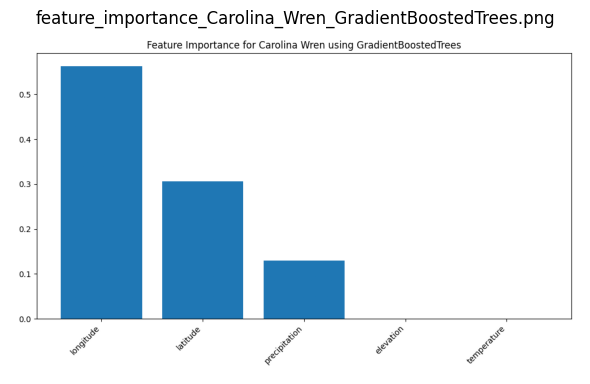

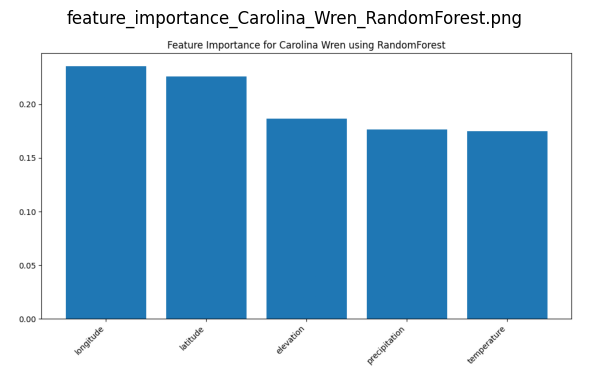

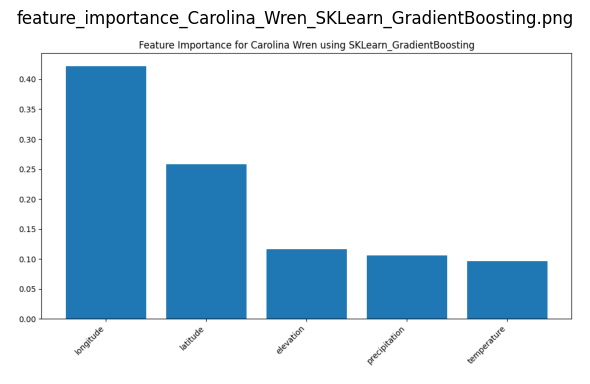

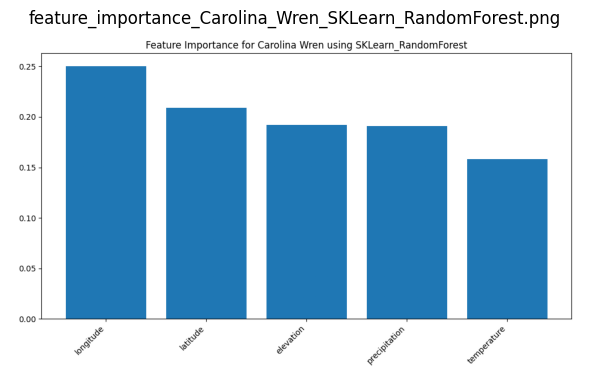

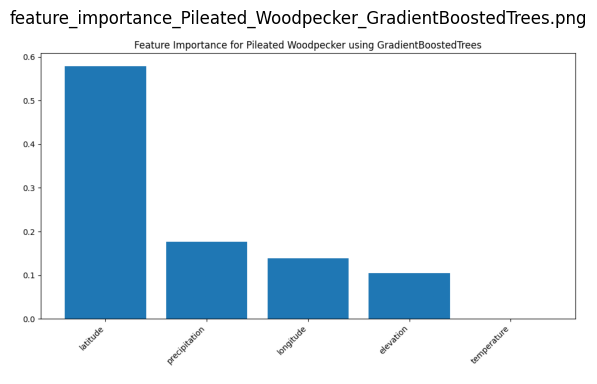

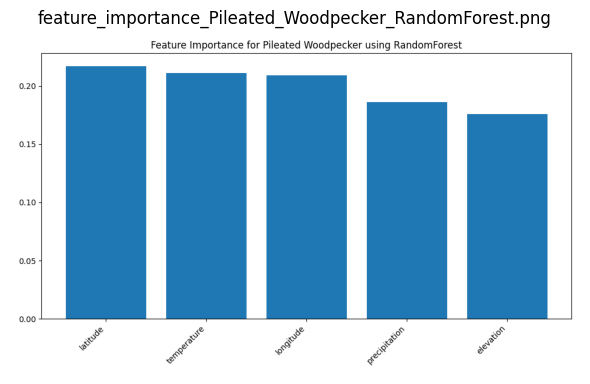

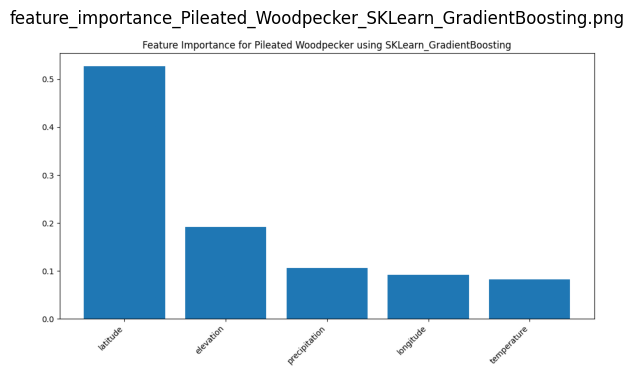

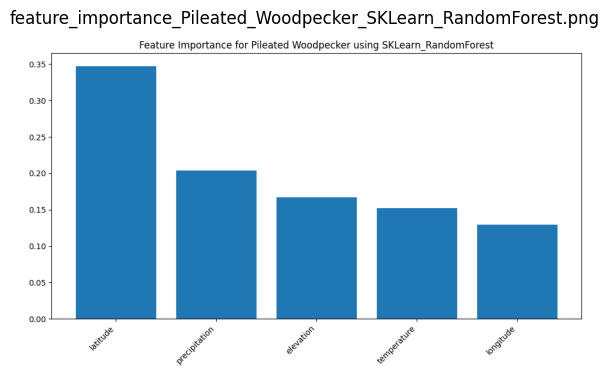

In [20]:
# Display all images in the images directory
def plot_images(image_dir='../../images/TabularImages/png'):
    image_files = [img for img in os.listdir(image_dir) if img.endswith('.png')]

    image_files.sort()

    for image_name in image_files:
        image_path = os.path.join(image_dir, image_name)
        img = mpimg.imread(image_path)

        plt.figure(figsize=(6, 5))
        plt.imshow(img)
        plt.axis('off')
        plt.title(image_name, fontsize=12)
        plt.tight_layout()
        plt.show()


plot_images()